# Batch Document Extraction with Llama Vision

Streamlined batch processing notebook using modular components.

**Features:**
- Early model loading
- Configurable output directory
- Comprehensive analytics and visualizations
- Clean, modular code structure

## 1. Imports

In [13]:
#Cell 1
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'

# Standard library imports
import warnings
from datetime import datetime
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
from IPython.display import display, Image
from rich import print as rprint
from rich.console import Console

# Project-specific imports
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from common.llama_model_loader_robust import load_llama_model_robust

print("‚úÖ All imports loaded successfully")
print("‚úÖ Llama batch processing modules imported successfully")
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
‚úÖ All imports loaded successfully
‚úÖ Llama batch processing modules imported successfully


## 2. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [2]:
#Cell 2
# Initialize console for rich output
console = Console()# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]üßπ PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]üí° This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]‚úÖ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]üìã Next: Import modules and configure settings[/dim]")

üßπ PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

üí° This prevents OOM errors when switching between models on V100

üö® Running V100 emergency GPU cleanup...
üßπ Starting V100-optimized GPU memory cleanup...
   üìä Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ‚úÖ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   üíæ Memory freed: 0.00GB
‚úÖ V100-optimized memory cleanup complete
‚úÖ V100 emergency cleanup complete


‚úÖ Memory cleanup complete - ready for model loading

üìã Next: Import modules and configure settings

## 3. Configuration

In [3]:
#Cell 3
# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    # 'MODEL_PATH': "/efs/shared/PTM/Llama-3.2-11B-Vision-Instruct",
    'MODEL_PATH': "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct",

    # Batch settings - Using base path for consistency
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    # 'OUTPUT_BASE': f'{base_data_path}/output',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)

    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,

    # L40S optimization settings
    'USE_QUANTIZATION': False,
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,  # Reduced for L40S (was 4000 for V100)
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/generated/llama_invoice_prompt.yaml',
        'RECEIPT': 'prompts/generated/llama_receipt_prompt.yaml',
        'BANK_STATEMENT': 'prompts/generated/llama_bank_statement_prompt.yaml'
    },
    
    # Extraction prompt key mapping (OPTIONAL - for explicit control)
    # Uncomment and configure to override automatic key derivation
    # 'extraction_keys': {
    #     'INVOICE': 'invoice',
    #     'RECEIPT': 'receipt',
    #     'BANK_STATEMENT': 'bank_statement',  # Will auto-append _flat or _date_grouped
    #     # Or specify full key to skip automatic structure suffix:
    #     # 'BANK_STATEMENT': 'bank_statement_flat',  # Forces flat table prompt
    # }
}

# Example configurations:
# ----------------------
# Use old prompts:
#   'extraction_files': {
#       'INVOICE': 'prompts/llama_prompts.yaml',
#       'RECEIPT': 'prompts/llama_prompts.yaml',
#       'BANK_STATEMENT': 'prompts/llama_prompts.yaml'
#   }
#
# Mix old and new prompts:
#   'extraction_files': {
#       'INVOICE': 'prompts/generated/llama_invoice_prompt.yaml',
#       'RECEIPT': 'prompts/llama_prompts.yaml',
#       'BANK_STATEMENT': 'prompts/generated/llama_bank_statement_prompt.yaml'
#   }
#
# Force specific bank statement structure:
#   'extraction_keys': {
#       'BANK_STATEMENT': 'bank_statement_flat'  # Ignores vision classification
#   }

print("‚úÖ Configuration set up successfully")
print(f"üìÇ Data directory: {CONFIG['DATA_DIR']}")
print(f"üìä Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"ü§ñ Model path: {CONFIG['MODEL_PATH']}")
print(f"üìÅ Output base: {CONFIG['OUTPUT_BASE']}")
print(f"üéØ Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")

‚úÖ Configuration set up successfully
üìÇ Data directory: /home/jovyan/nfs_share/tod/evaluation_data
üìä Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv
ü§ñ Model path: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct
üìÅ Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
üéØ Mode: Evaluation mode


## 4. Output Directory Setup

In [4]:
#Cell 4
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

## 5. Model Loading

In [5]:
#Cell 5
# Load model once for entire batch
rprint("[bold green]Loading model with robust multi-GPU detection...[/bold green]")

model, processor = load_llama_model_robust(
    model_path=CONFIG['MODEL_PATH'],
    use_quantization=CONFIG['USE_QUANTIZATION'],
    device_map=CONFIG['DEVICE_MAP'],
    max_new_tokens=CONFIG['MAX_NEW_TOKENS'],
    torch_dtype=CONFIG['TORCH_DTYPE'],
    low_cpu_mem_usage=CONFIG['LOW_CPU_MEM_USAGE'],
    verbose=CONFIG['VERBOSE']
)

# Model and processor will be used directly by DocumentAwareLlamaProcessor in batch processing
rprint("[bold green]‚úÖ Model ready for document-aware processing with robust detection[/bold green]")

Loading model with robust multi-GPU detection...

üöÄ Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

üîß Configuring CUDA memory for Llama...

üîß CUDA memory allocation configured: max_split_size_mb:64
üí° Using 64MB memory blocks to reduce fragmentation
üìä Initial CUDA state (Multi-GPU Total): Allocated=0.00GB, Reserved=0.00GB


üîç Performing robust GPU memory detection...

üîç Starting robust GPU memory detection...
üìä Detected 2 GPU(s), analyzing each device...
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available

üîç ROBUST GPU MEMORY DETECTION REPORT
‚úÖ Success: 2/2 GPUs detected
üìä Total Memory: 279.44GB
üíæ Available Memory: 279.44GB
‚ö° Allocated Memory: 0.00GB
üîÑ Reserved Memory: 0.00GB
üì¶ Fragmentation: 0.00GB
üñ•Ô∏è  Multi-GPU: Yes
‚öñÔ∏è  Balanced Distribution: Yes

üìã Per-GPU Breakdown:
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)


üìä GPU Hardware: NVIDIA H200 (2x 140GB = 279GB total)

üèóÔ∏è Architecture: datacenter_high_memory (dynamic detection)

üéØ Model: Llama-3.2-11B-Vision (estimated need: 22GB + 6.0GB buffer)

üíæ Available Memory: 279.4GB across 2 GPU(s)

üí° Memory sufficient: ‚úÖ Yes

‚úÖ datacenter_high_memory with 279GB - running in full precision as requested

üìä FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 279GB

   Available Memory: 279GB

Model needs: ~22GB + 6.0GB buffer for Llama-3.2-11B-Vision

   Working GPUs: 2/2

üöÄ Using 16-bit precision for optimal performance

Loading Llama Vision model...

üîÑ Auto-distributing model across 2 GPUs...

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading processor...

‚úÖ Model and processor loaded successfully!

üîÑ Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA H200): 9.8GB/150GB (6.5%)

GPU 1 (NVIDIA H200): 11.6GB/150GB (7.7%)

üìä Total across all GPUs: 21.3GB allocated, 21.3GB reserved, 300GB capacity

‚úÖ Model successfully distributed across GPUs

0: 18 modules

1: 28 modules

                            üîß Llama Vision Model Configuration                            
‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Setting             ‚îÉ Value                         ‚îÉ Llama Status                      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ Model Path          ‚îÇ Llama-3.2-11B-Vision-Instruct ‚îÇ ‚úÖ Valid                          ‚îÇ
‚îÇ Device Placement    ‚îÇ cuda:0                        ‚îÇ ‚úÖ Loaded                         ‚îÇ
‚îÇ Quantization Method ‚îÇ 16-bit                        ‚îÇ ‚úÖ 16-bit (Performance Optimized) ‚îÇ
‚îÇ Data Type           ‚îÇ bfloat16                      ‚îÇ ‚úÖ Recommended                    ‚îÇ
‚îÇ Max New Tokens      ‚îÇ 2000                          ‚îÇ ‚úÖ Generation Ready               ‚îÇ
‚îÇ GPU Configuration   ‚îÇ 2x NVIDIA H200 (300GB)        ‚îÇ ‚úÖ 300GB Total                    ‚îÇ
‚îÇ Model Parameters    ‚îÇ 10,670,220,835                ‚îÇ ‚úÖ Loaded                         ‚îÇ
‚îÇ Memory Optimization ‚îÇ Llama Robust                  ‚îÇ ‚úÖ V100 Compatible                ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Running model compatibility test...

‚úÖ Model compatibility test passed

Performing initial memory cleanup...

üßπ Memory cleanup completed

üíæ Final state (Multi-GPU Total): Allocated=21.34GB, Reserved=21.35GB, Fragmentation=0.01GB

üéâ Llama Vision model loading and validation complete!

üîß Llama optimizations active: 16-bit precision, memory management, vision preservation

‚úÖ Model ready for document-aware processing with robust detection

## 6. Image Discovery

In [6]:
#Cell 6
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]‚úÖ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]üìã Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

üìä Ground truth CSV loaded with 9 rows and 20 columns
üìã Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
‚úÖ Using 'image_file' as image identifier column
‚úÖ Ground truth mapping created for 9 images


‚úÖ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


## 7. Batch Processing

In [7]:
#Cell 7
# Initialize batch processor with simplified, clean architecture
processor = BatchDocumentProcessor(
    model=model,
    processor=processor,
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch with CONFIG verbose setting for detailed field comparison
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]‚úÖ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]üìã Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

üìä Ground truth CSV loaded with 9 rows and 20 columns
üìã Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
‚úÖ Using 'image_file' as image identifier column
‚úÖ Ground truth mapping created for 9 images


‚úÖ Loaded ground truth for 9 images

üöÄ Starting Batch Processing

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Batch Extraction ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

Output()

Processing [1/9]: image_001.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is a RECEIPT, specifically a purchase receipt for Liberty Oil.

‚úÖ Detected Document Type: RECEIPT

üßπ Cleaning memory before extraction...

üìã FIELD EXTRACTION

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 2694 characters

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 06 082 698 025
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000
PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000
INVOICE_DATE: 05/08/2025
LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3
LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10
IS_GST_INCLUDED: true
GST_AMOUNT: $8.62
TOTAL_AMOUNT: $94.87

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 06 082 698 025

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 481 Bourke Street  Perth WA 6000

PAYER_NAME: Robert Taylor

PAYER_ADDRESS: 243 Adelaide Street  Perth WA 6000

INVOICE_DATE: 05/08/2025

LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel

LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3

LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70

LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10

IS_GST_INCLUDED: true

GST_AMOUNT: $8.62

TOTAL_AMOUNT: $94.87

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 14 fields from image_001.png

‚úì Accuracy: 100.0% for image_001.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: RECEIPT

‚úÖ BUSINESS_ABN: 06 082 698 025

‚úÖ SUPPLIER_NAME: Liberty Oil

‚úÖ BUSINESS_ADDRESS: 481 Bourke Street  Perth WA 6000

‚úÖ PAYER_NAME: Robert Taylor

‚úÖ PAYER_ADDRESS: 243 Adelaide Street  Perth WA 6000

‚úÖ INVOICE_DATE: 05/08/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel

‚úÖ LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3

‚úÖ LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70

‚úÖ LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10

‚úÖ IS_GST_INCLUDED: true

‚úÖ GST_AMOUNT: $8.62

‚úÖ TOTAL_AMOUNT: $94.87

üìä Ground truth loaded for image_001.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             RECEIPT                                  RECEIPT

‚úÖ        BUSINESS_ABN              06 082 698 025                           06 082 698 025

‚úÖ        SUPPLIER_NAME             Liberty Oil                              Liberty Oil

‚úÖ        BUSINESS_ADDRESS          481 Bourke Street  Perth WA 6000         481 Bourke Street Perth WA 6000

‚úÖ        PAYER_NAME                Robert Taylor                            Robert Taylor

‚úÖ        PAYER_ADDRESS             243 Adelaide Street  Perth WA 6000       243 Adelaide Street Perth WA 6000

‚úÖ        INVOICE_DATE              05/08/2025                               05/08/2025

‚úÖ        LINE_ITEM_DESCRIPTIONS    Car Wash | Coffee Large | Unleaded Pet... Car Wash | Coffee Large | Unleaded 
Pet...

‚úÖ        LINE_ITEM_QUANTITIES      3 | 1 | 1 | 2 | 3                        3 | 1 | 1 | 2 | 3

‚úÖ        LINE_ITEM_PRICES          $15.00 | $4.50 | $1.65 | $15.00 | $1.7... $15.00 | $4.50 | $1.65 | $15.00 | 
$1.7...

‚úÖ        LINE_ITEM_TOTAL_PRICES    $45.00 | $4.50 | $1.65 | $30.00 | $5.1... $45.00 | $4.50 | $1.65 | $30.00 | 
$5.1...

‚úÖ        IS_GST_INCLUDED           true                                     true

‚úÖ        GST_AMOUNT                $8.62                                    $8.62

‚úÖ        TOTAL_AMOUNT              $94.87                                   $94.87

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 14/14 (100.0%)

üéØ Exact Matches: 14/14 (100.0%)

üìà Extraction Success Rate: 100.0%

‚è±Ô∏è Accuracy (matches/total): 100.0%

ü§ñ Document Type: RECEIPT

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

Processing [2/9]: image_002.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a RECEIPT.

‚úÖ Detected Document Type: RECEIPT

üßπ Cleaning memory before extraction...

üìã FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 2748 characters

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 298 483 258
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800
PAYER_NAME: Sophie Martin
PAYER_ADDRESS: 487 Collins Street, Hobart TAS 7000
INVOICE_DATE: 18/07/2025
LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50
IS_GST_INCLUDED: true
GST_AMOUNT: $5.20
TOTAL_AMOUNT: $57.15

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 298 483 258

SUPPLIER_NAME: Ampol Limited

BUSINESS_ADDRESS: 680 Collins Street  Darwin NT 0800

PAYER_NAME: Sophie Martin

PAYER_ADDRESS: 487 Collins Street  Hobart TAS 7000

INVOICE_DATE: 18/07/2025

LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded

LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2

LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75

LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50

IS_GST_INCLUDED: true

GST_AMOUNT: $5.20

TOTAL_AMOUNT: $57.15

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 14 fields from image_002.png

‚úì Accuracy: 92.6% for image_002.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: RECEIPT

‚úÖ BUSINESS_ABN: 298 483 258

‚úÖ SUPPLIER_NAME: Ampol Limited

‚úÖ BUSINESS_ADDRESS: 680 Collins Street  Darwin NT 0800

‚úÖ PAYER_NAME: Sophie Martin

‚úÖ PAYER_ADDRESS: 487 Collins Street  Hobart TAS 7000

‚úÖ INVOICE_DATE: 18/07/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded

‚úÖ LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2

‚úÖ LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75

‚úÖ LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50

‚úÖ IS_GST_INCLUDED: true

‚úÖ GST_AMOUNT: $5.20

‚úÖ TOTAL_AMOUNT: $57.15

üìä Ground truth loaded for image_002.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             RECEIPT                                  RECEIPT

‚ùå        BUSINESS_ABN              298 483 258                              29 466 483 258

  ‚ö†Ô∏è MISMATCH DETAILS (F1=0.0%, P=0.0%, R=0.0%):

     Extracted (full): 298 483 258

     Ground Truth (full): 29 466 483 258

     Metrics: TP=0, FP=1, FN=1

     Simple text/value mismatch

‚úÖ        SUPPLIER_NAME             Ampol Limited                            Ampol Limited

‚úÖ        BUSINESS_ADDRESS          680 Collins Street  Darwin NT 0800       680 Collins Street Darwin NT 0800

‚úÖ        PAYER_NAME                Sophie Martin                            Sophie Martin

‚âà        PAYER_ADDRESS             487 Collins Street  Hobart TAS 7000      467 Collins Street Hobart TAS 7000

  ‚ö†Ô∏è MISMATCH DETAILS (F1=97.1%, P=97.1%, R=97.1%):

     Extracted (full): 487 Collins Street  Hobart TAS 7000

     Ground Truth (full): 467 Collins Street Hobart TAS 7000

     Metrics: TP=1, FP=0, FN=0

     Simple text/value mismatch

‚úÖ        INVOICE_DATE              18/07/2025                               18/07/2025

‚úÖ        LINE_ITEM_DESCRIPTIONS    Energy Drink | Premium Unleaded | Coff... Energy Drink | Premium Unleaded | 
Coff...

‚úÖ        LINE_ITEM_QUANTITIES      1 | 1 | 2 | 2 | 2 | 2                    1 | 1 | 2 | 2 | 2 | 2

‚úÖ        LINE_ITEM_PRICES          $4.20 | $1.75 | $4.50 | $1.75 | $15.00... $4.20 | $1.75 | $4.50 | $1.75 | 
$15.00...

‚úÖ        LINE_ITEM_TOTAL_PRICES    $4.20 | $1.75 | $9.00 | $3.50 | $30.00... $4.20 | $1.75 | $9.00 | $3.50 | 
$30.00...

‚úÖ        IS_GST_INCLUDED           true                                     true

‚úÖ        GST_AMOUNT                $5.20                                    $5.20

‚úÖ        TOTAL_AMOUNT              $57.15                                   $57.15

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 14/14 (100.0%)

üéØ Exact Matches: 12/14 (85.7%)

üìà Extraction Success Rate: 92.6%

‚è±Ô∏è Accuracy (matches/total): 92.6%

ü§ñ Document Type: RECEIPT

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

Processing [3/9]: image_003.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a bank statement.

‚úÖ Detected Document Type: BANK_STATEMENT

üßπ Cleaning memory before extraction...

üîç Analyzing bank statement structure: image_003.png

ü§ñ Using VLM for structure analysis...

üìã VLM response: 'FLAT'

üß† Analysis: date_indicators=False, flat_indicators=True

üìä Triggered flat indicators: ['FLAT']

üìã Classification Result: FLAT

Description: Continuous table format with column headers

üí° Will use flat table extraction prompt

üè¶ Bank statement structure: flat

üìÅ Using prompt: llama_prompts.yaml (bank_statement_flat)

üìã FIELD EXTRACTION

Creating extraction processor with 5 fields for BANK_STATEMENT

Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS... (5 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer specializing in bank statement extraction.
Extract structured data from the transaction table for taxpayer's expense claims.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE: BANK_STATEMENT"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after "TRANSACTION_AMOUNTS_PAID:" with no additional text
- NO explanations, NO comments, NO additional text

## STEP 1: LOCATE THE TRANSACTION TABLE
Focus on the main transaction table in the document, typically located in the center/body area.
The table will have columns including: Date, Description, Debit/Withdrawal, Credit/Deposit, Balance.
Ignore page headers, footers, account summaries, and advertisement sections.

## STEP 2: IDENTIFY DEBIT TRANSACTIONS
TARGET COLUMNS: Date column + Description column + Debit/Withdrawal amount column

For each table row, check:
- Does it have a value in the DEBIT/WITHDRAWAL column? ‚Üí Extract this row
- Does it have a value in the CREDIT/DEPOSIT column only? ‚Üí SKIP this row
- Keywords indicating DEBIT: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, transfer out
- Keywords indicating CREDIT to skip: deposit, credit, salary, transfer in, interest received, refund

## STEP 3: EXTRACT ROW-BY-ROW
For EACH debit tra...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 3587 characters

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 03/05/2025 to 10/05/2025
TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/2025
LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | DIRECT 
CREDIT SALARY | ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | INTEREST PAYMENT | ATM WITHDRAWAL ANZ ATM
TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72 | $5.16

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: BANK_STATEMENT

STATEMENT_DATE_RANGE: 03/05/2025 to 10/05/2025

LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
DIRECT CREDIT SA...

TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/202...

TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72 | $5.16

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 5 fields from image_003.png

üéØ Evaluating using mathematically corrected values (not raw VLM output)

‚úì Accuracy: 80.3% for image_003.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=5

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: BANK_STATEMENT

‚úÖ STATEMENT_DATE_RANGE: 03/05/2025 to 10/05/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
DIRECT CREDIT SALARY | ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | INTEREST PAYMENT | ATM WITHDRAWAL ANZ 
ATM

‚úÖ TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/2025

‚úÖ TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72 | $5.16

üìä Ground truth loaded for image_003.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             BANK_STATEMENT                           BANK_STATEMENT

‚úÖ        STATEMENT_DATE_RANGE      03/05/2025 to 10/05/2025                 03/05/2025 to 10/05/2025

‚ùå        LINE_ITEM_DESCRIPTIONS    ONLINE PURCHASE AMAZON AU | EFTPOS PUR... ONLINE PURCHASE AMAZON AU | EFTPOS 
PUR...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=54.5%, P=60.0%, R=50.0%):

     Extracted (full): ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | DIRECT 
CREDIT SALARY | ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | INTEREST PAYMENT | ATM WITHDRAWAL ANZ ATM

     Ground Truth (full): ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | ATM 
WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | ATM WITHDRAWAL ANZ ATM

     Metrics: TP=3, FP=2, FN=3

     List comparison: 8 extracted vs 6 ground truth

     True Positives (correct): 3

     False Positives (extra): 2

     False Negatives (missing): 3

     ‚úì Correct (position-aware):

       Pos 0: ONLINE PURCHASE AMAZON AU

       Pos 1: EFTPOS PURCHASE COLES EXP

       Pos 2: EFTPOS PURCHASE COLES EXP

     ‚âà Wrong at position:

       Pos 3: 'DIRECT CREDIT SALARY' vs 'ATM WITHDRAWAL ANZ ATM'

       Pos 4: 'ATM WITHDRAWAL ANZ ATM' vs 'EFTPOS PURCHASE COLES EXP'

       Pos 5: 'EFTPOS PURCHASE COLES EXP' vs 'ATM WITHDRAWAL ANZ ATM'

     + Extra (extracted beyond GT length):

       Pos 6: INTEREST PAYMENT

       Pos 7: ATM WITHDRAWAL ANZ ATM

‚ùå        TRANSACTION_DATES         03/05/2025 | 04/05/2025 | 05/05/2025 |... 03/05/2025 | 04/05/2025 | 05/05/2025 
|...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=54.5%, P=60.0%, R=50.0%):

     Extracted (full): 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/2025

     Ground Truth (full): 03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025

     Metrics: TP=3, FP=2, FN=3

     List comparison: 8 extracted vs 6 ground truth

     True Positives (correct): 3

     False Positives (extra): 2

     False Negatives (missing): 3

     ‚úì Correct (position-aware):

       Pos 0: 03/05/2025

       Pos 1: 04/05/2025

       Pos 2: 05/05/2025

     ‚âà Wrong at position:

       Pos 3: '06/05/2025' vs '07/05/2025'

       Pos 4: '07/05/2025' vs '08/05/2025'

       Pos 5: '08/05/2025' vs '10/05/2025'

     + Extra (extracted beyond GT length):

       Pos 6: 09/05/2025

       Pos 7: 10/05/2025

‚âà        TRANSACTION_AMOUNTS_PAID  $288.03 | $22.50 | $114.66 | $187.59 |... $288.03 | $22.50 | $114.66 | $187.59 
|...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=92.3%, P=85.7%, R=100.0%):

     Extracted (full): $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72 | $5.16

     Ground Truth (full): $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72

     Metrics: TP=6, FP=1, FN=0

     List comparison: 7 extracted vs 6 ground truth

     True Positives (correct): 6

     False Positives (extra): 1

     False Negatives (missing): 0

     ‚úì Correct (position-aware): (+3 more)

       Pos 0: $288.03

       Pos 1: $22.50

       Pos 2: $114.66

     + Extra (extracted beyond GT length):

       Pos 6: $5.16

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 5/5 (100.0%)

üéØ Exact Matches: 2/5 (40.0%)

üìà Extraction Success Rate: 80.3%

‚è±Ô∏è Accuracy (matches/total): 80.3%

ü§ñ Document Type: BANK_STATEMENT

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

Processing [4/9]: image_004.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is a receipt, as it includes details of a purchase made at Liberty Oil, such as the date, time, items
purchased, and total amount paid.

‚úÖ Detected Document Type: RECEIPT

üßπ Cleaning memory before extraction...

üìã FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 2630 characters

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 66 658 925 499
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800
PAYER_NAME: William Harris
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800
INVOICE_DATE: 19/07/2025
LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol
LINE_ITEM_QUANTITIES: 1 | 2 | 3
LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95
IS_GST_INCLUDED: true
GST_AMOUNT: $1.01
TOTAL_AMOUNT: $11.11

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 66 658 925 499

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 993 Pitt Street  Darwin NT 0800

PAYER_NAME: William Harris

PAYER_ADDRESS: 52 Bourke Street  Darwin NT 0800

INVOICE_DATE: 19/07/2025

LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol

LINE_ITEM_QUANTITIES: 1 | 2 | 3

LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65

LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95

IS_GST_INCLUDED: true

GST_AMOUNT: $1.01

TOTAL_AMOUNT: $11.11

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 14 fields from image_004.png

‚úì Accuracy: 100.0% for image_004.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: RECEIPT

‚úÖ BUSINESS_ABN: 66 658 925 499

‚úÖ SUPPLIER_NAME: Liberty Oil

‚úÖ BUSINESS_ADDRESS: 993 Pitt Street  Darwin NT 0800

‚úÖ PAYER_NAME: William Harris

‚úÖ PAYER_ADDRESS: 52 Bourke Street  Darwin NT 0800

‚úÖ INVOICE_DATE: 19/07/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol

‚úÖ LINE_ITEM_QUANTITIES: 1 | 2 | 3

‚úÖ LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65

‚úÖ LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95

‚úÖ IS_GST_INCLUDED: true

‚úÖ GST_AMOUNT: $1.01

‚úÖ TOTAL_AMOUNT: $11.11

üìä Ground truth loaded for image_004.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             RECEIPT                                  RECEIPT

‚úÖ        BUSINESS_ABN              66 658 925 499                           66 658 925 499

‚úÖ        SUPPLIER_NAME             Liberty Oil                              Liberty Oil

‚úÖ        BUSINESS_ADDRESS          993 Pitt Street  Darwin NT 0800          993 Pitt Street Darwin NT 0800

‚úÖ        PAYER_NAME                William Harris                           William Harris

‚úÖ        PAYER_ADDRESS             52 Bourke Street  Darwin NT 0800         52 Bourke Street Darwin NT 0800

‚úÖ        INVOICE_DATE              19/07/2025                               19/07/2025

‚úÖ        LINE_ITEM_DESCRIPTIONS    Premium Unleaded | Diesel | Unleaded P... Premium Unleaded | Diesel | Unleaded 
P...

‚úÖ        LINE_ITEM_QUANTITIES      1 | 2 | 3                                1 | 2 | 3

‚úÖ        LINE_ITEM_PRICES          $1.75 | $1.70 | $1.65                    $1.75 | $1.70 | $1.65

‚úÖ        LINE_ITEM_TOTAL_PRICES    $1.75 | $3.40 | $4.95                    $1.75 | $3.40 | $4.95

‚úÖ        IS_GST_INCLUDED           true                                     true

‚úÖ        GST_AMOUNT                $1.01                                    $1.01

‚úÖ        TOTAL_AMOUNT              $11.11                                   $11.11

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 14/14 (100.0%)

üéØ Exact Matches: 14/14 (100.0%)

üìà Extraction Success Rate: 100.0%

‚è±Ô∏è Accuracy (matches/total): 100.0%

ü§ñ Document Type: RECEIPT

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

Processing [5/9]: image_005.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is an invoice, specifically a tax invoice, which includes details such as the business name, address,
and contact information, as well as a list of items purchased, their quantities, prices, and total cost.

‚úÖ Detected Document Type: INVOICE

üßπ Cleaning memory before extraction...

üìã FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 2766 characters

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000
PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000
INVOICE_DATE: 06/08/2025
LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24
IS_GST_INCLUDED: true
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 73 154 562 747

SUPPLIER_NAME: Aussie Office Supplies Pty Ltd

BUSINESS_ADDRESS: 123 Collins Street  Melbourne VIC 3000

PAYER_NAME: Perth Building Materials

PAYER_ADDRESS: 456 George Street  Sydney NSW 2000

INVOICE_DATE: 06/08/2025

LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand

LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1

LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24

LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24

IS_GST_INCLUDED: true

GST_AMOUNT: $439.46

TOTAL_AMOUNT: $4834.03

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 14 fields from image_005.png

‚úì Accuracy: 100.0% for image_005.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: INVOICE

‚úÖ BUSINESS_ABN: 73 154 562 747

‚úÖ SUPPLIER_NAME: Aussie Office Supplies Pty Ltd

‚úÖ BUSINESS_ADDRESS: 123 Collins Street  Melbourne VIC 3000

‚úÖ PAYER_NAME: Perth Building Materials

‚úÖ PAYER_ADDRESS: 456 George Street  Sydney NSW 2000

‚úÖ INVOICE_DATE: 06/08/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand

‚úÖ LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1

‚úÖ LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24

‚úÖ LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24

‚úÖ IS_GST_INCLUDED: true

‚úÖ GST_AMOUNT: $439.46

‚úÖ TOTAL_AMOUNT: $4834.03

üìä Ground truth loaded for image_005.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             INVOICE                                  INVOICE

‚úÖ        BUSINESS_ABN              73 154 562 747                           73 154 562 747

‚úÖ        SUPPLIER_NAME             Aussie Office Supplies Pty Ltd           Aussie Office Supplies Pty Ltd

‚úÖ        BUSINESS_ADDRESS          123 Collins Street  Melbourne VIC 3000   123 Collins Street Melbourne VIC 3000

‚úÖ        PAYER_NAME                Perth Building Materials                 Perth Building Materials

‚úÖ        PAYER_ADDRESS             456 George Street  Sydney NSW 2000       456 George Street Sydney NSW 2000

‚úÖ        INVOICE_DATE              06/08/2025                               06/08/2025

‚úÖ        LINE_ITEM_DESCRIPTIONS    Wireless Mouse | Desk Lamp | Wireless ... Wireless Mouse | Desk Lamp | Wireless
...

‚úÖ        LINE_ITEM_QUANTITIES      3 | 3 | 2 | 3 | 1                        3 | 3 | 2 | 3 | 1

‚úÖ        LINE_ITEM_PRICES          $490.12 | $38.84 | $431.58 | $138.58 |... $490.12 | $38.84 | $431.58 | $138.58 
|...

‚úÖ        LINE_ITEM_TOTAL_PRICES    $1470.35 | $116.53 | $863.17 | $415.74... $1470.35 | $116.53 | $863.17 | 
$415.74...

‚úÖ        IS_GST_INCLUDED           true                                     true

‚úÖ        GST_AMOUNT                $439.46                                  $439.46

‚úÖ        TOTAL_AMOUNT              $4834.03                                 $4834.03

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 14/14 (100.0%)

üéØ Exact Matches: 14/14 (100.0%)

üìà Extraction Success Rate: 100.0%

‚è±Ô∏è Accuracy (matches/total): 100.0%

ü§ñ Document Type: INVOICE

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

[5/9] image_005.png: INVOICE - Accuracy: 100.0% - Time: 9.01s

Processing [6/9]: image_006.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is an INVOICE.

‚úÖ Detected Document Type: INVOICE

üßπ Cleaning memory before extraction...

üìã FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 2843 characters

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931
PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156
INVOICE_DATE: 27/08/2025
LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00
IS_GST_INCLUDED: true
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 26 668 321 195

SUPPLIER_NAME: Maritime Mechanics

BUSINESS_ADDRESS: 1/92 Watt Road  Mornington  VIC 3931

PAYER_NAME: Tod Nestor

PAYER_ADDRESS: 29 Frederick Street  FERNTREE GULLY VIC 3156

INVOICE_DATE: 27/08/2025

LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete
| Freight ...

LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0

LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00

LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00

IS_GST_INCLUDED: true

GST_AMOUNT: $374.98

TOTAL_AMOUNT: $4,124.82

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 14 fields from image_006.png

‚úì Accuracy: 99.5% for image_006.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: INVOICE

‚úÖ BUSINESS_ABN: 26 668 321 195

‚úÖ SUPPLIER_NAME: Maritime Mechanics

‚úÖ BUSINESS_ADDRESS: 1/92 Watt Road  Mornington  VIC 3931

‚úÖ PAYER_NAME: Tod Nestor

‚úÖ PAYER_ADDRESS: 29 Frederick Street  FERNTREE GULLY VIC 3156

‚úÖ INVOICE_DATE: 27/08/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In

‚úÖ LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0

‚úÖ LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00

‚úÖ LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00

‚úÖ IS_GST_INCLUDED: true

‚úÖ GST_AMOUNT: $374.98

‚úÖ TOTAL_AMOUNT: $4,124.82

üìä Ground truth loaded for image_006.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             INVOICE                                  INVOICE

‚úÖ        BUSINESS_ABN              26 668 321 195                           26 668 321 195

‚úÖ        SUPPLIER_NAME             Maritime Mechanics                       Maritime Mechanics

‚úÖ        BUSINESS_ADDRESS          1/92 Watt Road  Mornington  VIC 3931     1/92 Watt Road Mornington VIC 3931

‚úÖ        PAYER_NAME                Tod Nestor                               Tod Nestor

‚úÖ        PAYER_ADDRESS             29 Frederick Street  FERNTREE GULLY VI... 29 Frederick Street FERNTREE GULLY 
VIC...

‚úÖ        INVOICE_DATE              27/08/2025                               27/08/2025

‚úÖ        LINE_ITEM_DESCRIPTIONS    VRS Kit | Pushrods | Ex Valve | Inject... VRS Kit | Pushrods | Ex Valve | 
Inject...

‚úÖ        LINE_ITEM_QUANTITIES      1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.... 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 
1....

‚úÖ        LINE_ITEM_PRICES          $356.25 | $86.87 | $181.25 | $478.60 |... $356.25 | $86.87 | $181.25 | $478.60 
|...

‚âà        LINE_ITEM_TOTAL_PRICES    $356.25 | $173.74 | $181.25 | $478.60 ... $356.25 | $173.74 | $181.25 | $478.60 
...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=92.3%, P=100.0%, R=85.7%):

     Extracted (full): $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00

     Ground Truth (full): $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00

     Metrics: TP=6, FP=0, FN=1

     List comparison: 7 extracted vs 7 ground truth

     True Positives (correct): 6

     False Positives (extra): 0

     False Negatives (missing): 1

     ‚úì Correct (position-aware): (+3 more)

       Pos 0: $356.25

       Pos 1: $173.74

       Pos 2: $181.25

     ‚âà Wrong at position:

       Pos 5: '$1,530.00' vs '$1530.00'

‚úÖ        IS_GST_INCLUDED           true                                     true

‚úÖ        GST_AMOUNT                $374.98                                  $374.98

‚úÖ        TOTAL_AMOUNT              $4,124.82                                $4124.82

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 14/14 (100.0%)

üéØ Exact Matches: 13/14 (92.9%)

üìà Extraction Success Rate: 99.5%

‚è±Ô∏è Accuracy (matches/total): 99.5%

ü§ñ Document Type: INVOICE

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

Processing [7/9]: image_007.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is an invoice.

‚úÖ Detected Document Type: INVOICE

üßπ Cleaning memory before extraction...

üìã FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 2756 characters

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 64 086 174 781
SUPPLIER_NAME: Telstra Limited
BUSINESS_ADDRESS: ABN 64 086 174 781
PAYER_NAME: Mr Maurice Nestor
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156
INVOICE_DATE: 16 Jul 2025
LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409 
760 513 | Mobile data service 0428 992 418
LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00
LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00
IS_GST_INCLUDED: true
GST_AMOUNT: $10.91
TOTAL_AMOUNT: $120.00

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 64 086 174 781

SUPPLIER_NAME: Telstra Limited

BUSINESS_ADDRESS: ABN 64 086 174 781

PAYER_NAME: Mr Maurice Nestor

PAYER_ADDRESS: 29 Frederick Street  FERNTREE GULLY VIC 3156

INVOICE_DATE: 16/07/2025

LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409
760 513 | ...

LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1

LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00

LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00

IS_GST_INCLUDED: true

GST_AMOUNT: $10.91

TOTAL_AMOUNT: $120.00

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 14 fields from image_007.png

‚úì Accuracy: 92.9% for image_007.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: INVOICE

‚úÖ BUSINESS_ABN: 64 086 174 781

‚úÖ SUPPLIER_NAME: Telstra Limited

‚úÖ BUSINESS_ADDRESS: ABN 64 086 174 781

‚úÖ PAYER_NAME: Mr Maurice Nestor

‚úÖ PAYER_ADDRESS: 29 Frederick Street  FERNTREE GULLY VIC 3156

‚úÖ INVOICE_DATE: 16/07/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 
0409 760 513 | Mobile data service 0428 992 418

‚úÖ LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1

‚úÖ LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00

‚úÖ LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00

‚úÖ IS_GST_INCLUDED: true

‚úÖ GST_AMOUNT: $10.91

‚úÖ TOTAL_AMOUNT: $120.00

üìä Ground truth loaded for image_007.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             INVOICE                                  INVOICE

‚úÖ        BUSINESS_ABN              64 086 174 781                           64 086 174 781

‚úÖ        SUPPLIER_NAME             Telstra Limited                          Telstra Limited

‚ùå        BUSINESS_ADDRESS          ABN 64 086 174 781                       29 Frederick Street FernTree Gully 
VIC...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=0.0%, P=0.0%, R=0.0%):

     Extracted (full): ABN 64 086 174 781

     Ground Truth (full): 29 Frederick Street FernTree Gully VIC 3156

     Metrics: TP=0, FP=1, FN=1

     Simple text/value mismatch

‚úÖ        PAYER_NAME                Mr Maurice Nestor                        Mr Maurice Nestor

‚úÖ        PAYER_ADDRESS             29 Frederick Street  FERNTREE GULLY VI... 29 Frederick Street FernTree Gully 
VIC...

‚úÖ        INVOICE_DATE              16/07/2025                               16-Jul-25

‚úÖ        LINE_ITEM_DESCRIPTIONS    Mobile service 0428 521 734 | Mobile d... Mobile service 0428 521 734 | Mobile 
d...

‚úÖ        LINE_ITEM_QUANTITIES      1 | 1 | 1 | 1                            1 | 1 | 1 | 1

‚úÖ        LINE_ITEM_PRICES          $45.00 | $30.00 | $25.00 | $20.00        $45.00 | $30.00 | $25.00 | $20.00

‚úÖ        LINE_ITEM_TOTAL_PRICES    $45.00 | $30.00 | $25.00 | $20.00        $45.00 | $30.00 | $25.00 | $20.00

‚úÖ        IS_GST_INCLUDED           true                                     true

‚úÖ        GST_AMOUNT                $10.91                                   $10.91

‚úÖ        TOTAL_AMOUNT              $120.00                                  $120.00

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 14/14 (100.0%)

üéØ Exact Matches: 13/14 (92.9%)

üìà Extraction Success Rate: 92.9%

‚è±Ô∏è Accuracy (matches/total): 92.9%

ü§ñ Document Type: INVOICE

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚úÖ Yes

===================================================================================================================
=====

Processing [8/9]: image_008.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a bank statement, so the correct answer is: **BANK_STATEMENT**.

‚úÖ Detected Document Type: BANK_STATEMENT

üßπ Cleaning memory before extraction...

üîç Analyzing bank statement structure: image_008.png

ü§ñ Using VLM for structure analysis...

üìã VLM response: 'FLAT'

üß† Analysis: date_indicators=False, flat_indicators=True

üìä Triggered flat indicators: ['FLAT']

üìã Classification Result: FLAT

Description: Continuous table format with column headers

üí° Will use flat table extraction prompt

üè¶ Bank statement structure: flat

üìÅ Using prompt: llama_prompts.yaml (bank_statement_flat)

üìã FIELD EXTRACTION

Creating extraction processor with 5 fields for BANK_STATEMENT

Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS... (5 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer specializing in bank statement extraction.
Extract structured data from the transaction table for taxpayer's expense claims.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE: BANK_STATEMENT"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after "TRANSACTION_AMOUNTS_PAID:" with no additional text
- NO explanations, NO comments, NO additional text

## STEP 1: LOCATE THE TRANSACTION TABLE
Focus on the main transaction table in the document, typically located in the center/body area.
The table will have columns including: Date, Description, Debit/Withdrawal, Credit/Deposit, Balance.
Ignore page headers, footers, account summaries, and advertisement sections.

## STEP 2: IDENTIFY DEBIT TRANSACTIONS
TARGET COLUMNS: Date column + Description column + Debit/Withdrawal amount column

For each table row, check:
- Does it have a value in the DEBIT/WITHDRAWAL column? ‚Üí Extract this row
- Does it have a value in the CREDIT/DEPOSIT column only? ‚Üí SKIP this row
- Keywords indicating DEBIT: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, transfer out
- Keywords indicating CREDIT to skip: deposit, credit, salary, transfer in, interest received, refund

## STEP 3: EXTRACT ROW-BY-ROW
For EACH debit tra...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 5616 characters

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 08/08/2025 to 07/09/2025
TRANSACTION_DATES: 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 31/08/2025 | 
29/08/2025 | 27/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 | 22/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 
| 17/08/2025 | 14/08/2025 | 13/08/2025 | 11/08/2025 | 10/08/2025 | 09/08/2025 | 06/08/2025 | 05/08/2025 | 
04/08/2025
LINE_ITEM_DESCRIPTIONS: EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO... | Mortgage Repayment MORT 0103P16754533 NAB | OSKO Payment to MIKE CHEN 809B4B5773133 | Direct Debit 
15395P41608263 MWF 42730 | Salary Payment ATO 28782P6782109 | DD INSURANCE ACME CORP PTY LTD 82321942151853 | Auto 
Payment UTILITIES AGL 7947DPR85943944 | DIRECT CREDIT SALARY 6080P67812986 | BPAY Payment BILLER60279 CRN 
9813018480 | Professional Services Red Energy 98073P31959417 | Card Purchase RED ROOSTER Paramatta SA | Credit Card
Payment CC 72599P33283283 | EFTPOS Cash Out PRICELINE PHARMACY BRISBANE QLD | Card Purchase CHEMIST WAREHOUSE 
DISCOUNT Richmo... | Fortnightly Pay ATO PAYROLL 91032P35687918 | PAY RUN ACME CORP PTY LTD 99584P07785218 | Salary
Payment ATO 30175P32361415 | Online Purchase amazon.com.au AUS | Salary Payment ATO 28773P16041610 | Transfer To 
Vicks Account NetBank 54381P90841102 | Salary Payment ATO 94514P80490207 | Transfer To Western Port Marina NetBank 
From Tod | Subscription Netflix 33588P77385123 | Contactless Payment Cinema CAIRNS QLD | Auto Payment UTILITIES Red
Energy 15107P21771655 | Contactless Payment Restaurant MACKAY QLD | Fortnightly Pay ATO PAYROLL 36358P70254998 | 
Centrelink Payment JobSeeker 59392P56090878 | International Transaction Fee | Equipment Purchase OfficeMax 
Australia 13554P45... | International ATM USA USD | Dividend Payment PREMIUM CORP PTY LTD 7353SP419... | Invoice 
Payment HARVEY NORMAN FLAGSHIP PTY LTD... | Online Purchase ebay.com.au AUS | Subscription Spotify Monthly 
15369P58427775 | International Transaction Fee | Business Expense IT Equipment 66969P86141679 | Auto Payment 
UTILITIES Energy Australia 47683P7... | Auto Payment UTILITIES Red Energy 81338P61572286
TRANSACTION_AMOUNTS_PAID: $322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $37.68 | $270.31 | 
$1957.09 | $221.60 | $222.56 | $5679.21 | $4455.46 | $7951.93 | $6013.70 | $2345.10 | $728.48 | $201.14 | $211.28 |
$33.24 | $145.70 | $7201.19 | $2241.39 | $478.86 | $260.71 | $229.39 | $257.95 | $166.22 | $33.83 | $62.18 | $91.04
| $389.57

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: BANK_STATEMENT

STATEMENT_DATE_RANGE: 08/08/2025 to 07/09/2025

LINE_ITEM_DESCRIPTIONS: EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO... |...

TRANSACTION_DATES: 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 31/08/2025 | 
29/08/202...

TRANSACTION_AMOUNTS_PAID: $322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $37.68 | $270.31 |
$1957.09 | $...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 5 fields from image_008.png

üéØ Evaluating using mathematically corrected values (not raw VLM output)

‚úì Accuracy: 52.7% for image_008.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=5

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: BANK_STATEMENT

‚úÖ STATEMENT_DATE_RANGE: 08/08/2025 to 07/09/2025

‚úÖ LINE_ITEM_DESCRIPTIONS: EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO... | Mortgage Repayment MORT 0103P16754533 NAB | OSKO Payment to MIKE CHEN 809B4B5773133 | Direct Debit 
15395P41608263 MWF 42730 | Salary Payment ATO 28782P6782109 | DD INSURANCE ACME CORP PTY LTD 82321942151853 | Auto 
Payment UTILITIES AGL 7947DPR85943944 | DIRECT CREDIT SALARY 6080P67812986 | BPAY Payment BILLER60279 CRN 
9813018480 | Professional Services Red Energy 98073P31959417 | Card Purchase RED ROOSTER Paramatta SA | Credit Card
Payment CC 72599P33283283 | EFTPOS Cash Out PRICELINE PHARMACY BRISBANE QLD | Card Purchase CHEMIST WAREHOUSE 
DISCOUNT Richmo... | Fortnightly Pay ATO PAYROLL 91032P35687918 | PAY RUN ACME CORP PTY LTD 99584P07785218 | Salary
Payment ATO 30175P32361415 | Online Purchase amazon.com.au AUS | Salary Payment ATO 28773P16041610 | Transfer To 
Vicks Account NetBank 54381P90841102 | Salary Payment ATO 94514P80490207 | Transfer To Western Port Marina NetBank 
From Tod | Subscription Netflix 33588P77385123 | Contactless Payment Cinema CAIRNS QLD | Auto Payment UTILITIES Red
Energy 15107P21771655 | Contactless Payment Restaurant MACKAY QLD | Fortnightly Pay ATO PAYROLL 36358P70254998 | 
Centrelink Payment JobSeeker 59392P56090878 | International Transaction Fee | Equipment Purchase OfficeMax 
Australia 13554P45... | International ATM USA USD | Dividend Payment PREMIUM CORP PTY LTD 7353SP419... | Invoice 
Payment HARVEY NORMAN FLAGSHIP PTY LTD... | Online Purchase ebay.com.au AUS | Subscription Spotify Monthly 
15369P58427775 | International Transaction Fee | Business Expense IT Equipment 66969P86141679 | Auto Payment 
UTILITIES Energy Australia 47683P7... | Auto Payment UTILITIES Red Energy 81338P61572286

‚úÖ TRANSACTION_DATES: 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 31/08/2025 | 
29/08/2025 | 27/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 | 22/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 
| 17/08/2025 | 14/08/2025 | 13/08/2025 | 11/08/2025 | 10/08/2025 | 09/08/2025 | 06/08/2025 | 05/08/2025 | 
04/08/2025

‚úÖ TRANSACTION_AMOUNTS_PAID: $322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $37.68 | $270.31 
| $1957.09 | $221.60 | $222.56 | $5679.21 | $4455.46 | $7951.93 | $6013.70 | $2345.10 | $728.48 | $201.14 | $211.28
| $33.24 | $145.70 | $7201.19 | $2241.39 | $478.86 | $260.71 | $229.39 | $257.95 | $166.22 | $33.83 | $62.18 | 
$91.04 | $389.57

üìä Ground truth loaded for image_008.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             BANK_STATEMENT                           BANK_STATEMENT

‚úÖ        STATEMENT_DATE_RANGE      08/08/2025 to 07/09/2025                 08/08/2025 to 07/09/2025

‚ùå        LINE_ITEM_DESCRIPTIONS    EFTPOS Cash Out PRICELINE PHARMACY MAC... EFTPOS Cash Out PRICELINE PHARMACY 
MAC...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=4.9%, P=9.1%, R=3.3%):

     Extracted (full): EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO... | Mortgage Repayment MORT 0103P16754533 NAB | OSKO Payment to MIKE CHEN 809B4B5773133 | Direct Debit 
15395P41608263 MWF 42730 | Salary Payment ATO 28782P6782109 | DD INSURANCE ACME CORP PTY LTD 82321942151853 | Auto 
Payment UTILITIES AGL 7947DPR85943944 | DIRECT CREDIT SALARY 6080P67812986 | BPAY Payment BILLER60279 CRN 
9813018480 | Professional Services Red Energy 98073P31959417 | Card Purchase RED ROOSTER Paramatta SA | Credit Card
Payment CC 72599P33283283 | EFTPOS Cash Out PRICELINE PHARMACY BRISBANE QLD | Card Purchase CHEMIST WAREHOUSE 
DISCOUNT Richmo... | Fortnightly Pay ATO PAYROLL 91032P35687918 | PAY RUN ACME CORP PTY LTD 99584P07785218 | Salary
Payment ATO 30175P32361415 | Online Purchase amazon.com.au AUS | Salary Payment ATO 28773P16041610 | Transfer To 
Vicks Account NetBank 54381P90841102 | Salary Payment ATO 94514P80490207 | Transfer To Western Port Marina NetBank 
From Tod | Subscription Netflix 33588P77385123 | Contactless Payment Cinema CAIRNS QLD | Auto Payment UTILITIES Red
Energy 15107P21771655 | Contactless Payment Restaurant MACKAY QLD | Fortnightly Pay ATO PAYROLL 36358P70254998 | 
Centrelink Payment JobSeeker 59392P56090878 | International Transaction Fee | Equipment Purchase OfficeMax 
Australia 13554P45... | International ATM USA USD | Dividend Payment PREMIUM CORP PTY LTD 7353SP419... | Invoice 
Payment HARVEY NORMAN FLAGSHIP PTY LTD... | Online Purchase ebay.com.au AUS | Subscription Spotify Monthly 
15369P58427775 | International Transaction Fee | Business Expense IT Equipment 66969P86141679 | Auto Payment 
UTILITIES Energy Australia 47683P7... | Auto Payment UTILITIES Red Energy 81338P61572286

     Ground Truth (full): EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO | Mortgage Repayment MORT 6103P16754533 NAB | OSKO Payment to MIKE CHEN 60088P85773133 | Direct Debit 
15395P41808263 MHF 42730 | DD INSURANCE ACME CORP PTY LTD 82321P42151853 | Auto Payment UTILITIES AGL 
87840P85943944 | BPAY Payment BILLER60279 CRN 9013018480 | Professional Services Red Energy 68073P31959417 | Card 
Purchase RED ROOSTER Paramatta SA | Credit Card Payment CC 72599P33283298 | EFTPOS Cash Out PRICELINE PHARMACY 
BRISBANE QLD | Card Purchase CHEMIST WAREHOUSE DISCOUNT Richmo | Online Purchase amazon.com.au AUS | Transfer To 
Vicks Account NetBank 54381P90841102 | Transfer To Western Port Marina NetBank From Tod | Subscription Netflix 
33586P77385123 | Contactless Payment Cinema CAIRNS QLD | Auto Payment UTILITIES Red Energy 15107P21771655 | 
Contactless Payment Restaurant MACKAY QLD | International Transaction Fee | Equipment Purchase OfficeMax Australia 
13554P45 | International ATM USA USD | Invoice Payment HARVEY NORMAN FLAGSHIP PTY LTD | Online Purchase ebay.com.au
AUS | Subscription Spotify Monthly 15369P56427775 | International Transaction Fee | Business Expense IT Equipment 
66969P86141679 | Auto Payment UTILITIES Energy Australia 47683P7 | Auto Payment UTILITIES Red Energy 81338P61572286

     Metrics: TP=1, FP=10, FN=29

     List comparison: 40 extracted vs 30 ground truth

     True Positives (correct): 1

     False Positives (extra): 10

     False Negatives (missing): 29

     ‚úì Correct (position-aware):

       Pos 0: EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD

     ‚âà Wrong at position: (+26 more)

       Pos 1: 'EFTPOS Purchase OFFICEWORKS BUSINESS ROCKHAMPTO...' vs 'EFTPOS Purchase OFFICEWORKS BUSINESS 
ROCKHAMPTO'

       Pos 2: 'Mortgage Repayment MORT 0103P16754533 NAB' vs 'Mortgage Repayment MORT 6103P16754533 NAB'

       Pos 3: 'OSKO Payment to MIKE CHEN 809B4B5773133' vs 'OSKO Payment to MIKE CHEN 60088P85773133'

     + Extra (extracted beyond GT length): (+7 more)

       Pos 30: Equipment Purchase OfficeMax Australia 13554P45...

       Pos 31: International ATM USA USD

       Pos 32: Dividend Payment PREMIUM CORP PTY LTD 7353SP419...

‚ùå        TRANSACTION_DATES         07/09/2025 | 08/09/2025 | 04/09/2025 |... 07/09/2025 | 08/09/2025 | 04/09/2025 
|...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=23.5%, P=100.0%, R=13.3%):

     Extracted (full): 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 31/08/2025 | 
29/08/2025 | 27/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 | 22/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 
| 17/08/2025 | 14/08/2025 | 13/08/2025 | 11/08/2025 | 10/08/2025 | 09/08/2025 | 06/08/2025 | 05/08/2025 | 
04/08/2025

     Ground Truth (full): 07/09/2025 | 08/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 
| 01/09/2025 | 31/08/2025 | 29/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 23/08/2025 | 20/08/2025 | 
20/08/2025 | 19/08/2025 | 18/08/2025 | 18/08/2025 | 18/08/2025 | 14/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 
| 10/08/2025 | 10/08/2025 | 09/08/2025 | 09/08/2025 | 08/08/2025 | 08/08/2025

     Metrics: TP=4, FP=0, FN=26

     List comparison: 25 extracted vs 30 ground truth

     True Positives (correct): 4

     False Positives (extra): 0

     False Negatives (missing): 26

     ‚úì Correct (position-aware): (+1 more)

       Pos 0: 07/09/2025

       Pos 1: 08/09/2025

       Pos 2: 04/09/2025

     ‚âà Wrong at position: (+18 more)

       Pos 4: '02/09/2025' vs '03/09/2025'

       Pos 5: '01/09/2025' vs '02/09/2025'

       Pos 6: '31/08/2025' vs '01/09/2025'

     ‚úó Missing (in GT, not extracted): (+2 more)

       Pos 25: 10/08/2025

       Pos 26: 09/08/2025

       Pos 27: 09/08/2025

‚ùå        TRANSACTION_AMOUNTS_PAID  $322.18 | $64.33 | $649.79 | $1365.43 ... $322.18 | $64.33 | $649.79 | $1365.43
...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=35.0%, P=70.0%, R=23.3%):

     Extracted (full): $322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $37.68 | $270.31 | 
$1957.09 | $221.60 | $222.56 | $5679.21 | $4455.46 | $7951.93 | $6013.70 | $2345.10 | $728.48 | $201.14 | $211.28 |
$33.24 | $145.70 | $7201.19 | $2241.39 | $478.86 | $260.71 | $229.39 | $257.95 | $166.22 | $33.83 | $62.18 | $91.04
| $389.57

     Ground Truth (full): $322.18 | $64.33 | $649.79 | $1365.43 | $199.17 | $45.04 | $257.50 | $37.98 | $2457.87 | 
$270.31 | $1967.09 | $221.60 | $222.56 | $83.78 | $2345.10 | $726.48 | $201.14 | $211.28 | $33.24 | $145.70 | 
$27.06 | $478.89 | $260.71 | $229.39 | $297.95 | $186.22 | $33.83 | $925.18 | $91.94 | $388.67

     Metrics: TP=7, FP=3, FN=23

     List comparison: 33 extracted vs 30 ground truth

     True Positives (correct): 7

     False Positives (extra): 3

     False Negatives (missing): 23

     ‚úì Correct (position-aware): (+4 more)

       Pos 0: $322.18

       Pos 1: $64.33

       Pos 2: $649.79

     ‚âà Wrong at position: (+20 more)

       Pos 7: '$37.68' vs '$37.98'

       Pos 8: '$270.31' vs '$2457.87'

       Pos 9: '$1957.09' vs '$270.31'

     + Extra (extracted beyond GT length):

       Pos 30: $62.18

       Pos 31: $91.04

       Pos 32: $389.57

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 5/5 (100.0%)

üéØ Exact Matches: 2/5 (40.0%)

üìà Extraction Success Rate: 52.7%

‚è±Ô∏è Accuracy (matches/total): 52.7%

ü§ñ Document Type: BANK_STATEMENT

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚ùå No

===================================================================================================================
=====

Processing [9/9]: image_009.png

üîß Detection tokens - YAML: 200, Model config: 2000

üìã DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a bank statement, so the answer is: BANK_STATEMENT.

‚úÖ Detected Document Type: BANK_STATEMENT

üßπ Cleaning memory before extraction...

üîç Analyzing bank statement structure: image_009.png

ü§ñ Using VLM for structure analysis...

üìã VLM response: 'The transactions are grouped under shared date headers, so the answer is DATE_GROUPED.'

üß† Analysis: date_indicators=True, flat_indicators=False

üìÖ Triggered date indicators: ['DATE', 'GROUPED', 'HEADER', 'UNDER']

üìã Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

üí° Will use date-grouped extraction prompt

üè¶ Bank statement structure: date_grouped

üìÅ Using prompt: llama_prompts.yaml (bank_statement_date_grouped)

üìã FIELD EXTRACTION

Creating extraction processor with 5 fields for BANK_STATEMENT

Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS... (5 total)

üîß Using configured max_tokens: 2000 (from notebook CONFIG)

üìã EXTRACTION PROMPT:

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

You are an expert document analyzer specializing in bank statement extraction.
Extract transaction data from this Australian bank statement for taxpayer expense claims.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE: BANK_STATEMENT"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after "TRANSACTION_AMOUNTS_PAID:" with no additional text
- NO explanations, NO comments, NO additional text

## STEP 1: LOCATE DATE-GROUPED TRANSACTION SECTIONS
Focus on the main transaction area in the document body.
This statement has transactions grouped under date headers like "Thu 04 Sep 2025" or "Mon 01 Sep 2025".
Under each date header, there will be transaction rows with: Description, Amount columns.
Ignore page headers, footers, account summaries, and advertisement sections.

## STEP 2: IDENTIFY DEBIT TRANSACTIONS UNDER EACH DATE
For each date header section:
TARGET DATA: Transaction description + Transaction amount (look for negative amounts or explicit debit indicators)

For each transaction under a date header, check:
- Is this a DEBIT/WITHDRAWAL transaction (money OUT)? ‚Üí Extract this transaction
- Is this a CREDIT/DEPOSIT transaction (money IN)? ‚Üí SKIP this transaction
- Keywords indicating DEBIT: withdrawal, payment, purchase, debit, fee, ch...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìÑ RAW MODEL EXTRACTION RESPONSE:

Total response length: 4273 characters

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 07 Aug 2025 to 06 Sep 2025
TRANSACTION_DATES: 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025
LINE_ITEM_DESCRIPTIONS: Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdi ATM WBC 
WESTPAC GLEN WAVE | Direct Debit 94924P40133289 MHF 75969 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN 
REPAY 56052P41700670 | Salary - ATO PAYROLL 89278P11488578 | Direct Debit COLES PTY LTD | Cash Withdrawal ATM 
HOBART TAS | Transfer To Vicks Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY
LTD | ATM Withdrawal SYDNEY NSW | Transfer To Western Port Marina NetBank
TRANSACTION_AMOUNTS_PAID: $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $7836.75 | $276.31 | 
$61.68 | $3775.28 | $5778.51 | $245.00 | $51.36 | $4374.15 | $214.28

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úÖ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: BANK_STATEMENT

STATEMENT_DATE_RANGE: 07 Aug 2025 to 06 Sep 2025

LINE_ITEM_DESCRIPTIONS: Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdi ATM WBC 
WESTPAC GLEN...

TRANSACTION_DATES: 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/202...

TRANSACTION_AMOUNTS_PAID: $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $7836.75 | $276.31 
| $61.68 | $3...

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

‚úì Extracted 5 fields from image_009.png

üéØ Evaluating using mathematically corrected values (not raw VLM output)

‚úì Accuracy: 73.3% for image_009.png

üîç DEBUG: model_type=llama, has_field_scores=True, field_count=5

===================================================================================================================
=====

üìã STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

üîç EXTRACTED DATA:

‚úÖ DOCUMENT_TYPE: BANK_STATEMENT

‚úÖ STATEMENT_DATE_RANGE: 07 Aug 2025 to 06 Sep 2025

‚úÖ LINE_ITEM_DESCRIPTIONS: Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdi ATM WBC 
WESTPAC GLEN WAVE | Direct Debit 94924P40133289 MHF 75969 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN 
REPAY 56052P41700670 | Salary - ATO PAYROLL 89278P11488578 | Direct Debit COLES PTY LTD | Cash Withdrawal ATM 
HOBART TAS | Transfer To Vicks Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY
LTD | ATM Withdrawal SYDNEY NSW | Transfer To Western Port Marina NetBank

‚úÖ TRANSACTION_DATES: 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025

‚úÖ TRANSACTION_AMOUNTS_PAID: $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $7836.75 | $276.31
| $61.68 | $3775.28 | $5778.51 | $245.00 | $51.36 | $4374.15 | $214.28

üìä Ground truth loaded for image_009.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

‚úÖ        DOCUMENT_TYPE             BANK_STATEMENT                           BANK_STATEMENT

‚úÖ        STATEMENT_DATE_RANGE      07 Aug 2025 to 06 Sep 2025               07 Aug 2025 to 06 Sep 2025

‚ùå        LINE_ITEM_DESCRIPTIONS    Direct Debit DOMINO'S PTY LTD | Monthl... Direct Debit DOMINO'S PTY LTD | 
Monthl...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=42.1%, P=100.0%, R=26.7%):

     Extracted (full): Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdi ATM WBC 
WESTPAC GLEN WAVE | Direct Debit 94924P40133289 MHF 75969 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN 
REPAY 56052P41700670 | Salary - ATO PAYROLL 89278P11488578 | Direct Debit COLES PTY LTD | Cash Withdrawal ATM 
HOBART TAS | Transfer To Vicks Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY
LTD | ATM Withdrawal SYDNEY NSW | Transfer To Western Port Marina NetBank

     Ground Truth (full): Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM WBC 
WESTPAC GLEN WAVE | Direct Debit 94924P40133259 MHF 75600 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN 
REPAY 56052P41706670 | Direct Debit COLES PTY LTD | Cash Withdrawal ATM HOBART TAS | Transfer To Vicks Account 
NetBank From Tod | Direct Debit MYER PTY LTD | ATM Withdrawal SYDNEY NSW | Direct Debit 65452P29227883 MHF 11016 | 
Transfer To Western Port Marina NetBank | Direct Debit 82572P60016423 MHF 62020

     Metrics: TP=4, FP=0, FN=11

     List comparison: 15 extracted vs 15 ground truth

     True Positives (correct): 4

     False Positives (extra): 0

     False Negatives (missing): 11

     ‚úì Correct (position-aware): (+1 more)

       Pos 0: Direct Debit DOMINO'S PTY LTD

       Pos 1: Monthly Service Fee

       Pos 2: Monthly Service Fee

     ‚âà Wrong at position: (+8 more)

       Pos 3: 'Wdi ATM WBC WESTPAC GLEN WAVE' vs 'Wdl ATM WBC WESTPAC GLEN WAVE'

       Pos 4: 'Direct Debit 94924P40133289 MHF 75969' vs 'Direct Debit 94924P40133259 MHF 75600'

       Pos 6: 'Home Loan Payment LN REPAY 56052P41700670' vs 'Home Loan Payment LN REPAY 56052P41706670'

‚ùå        TRANSACTION_DATES         04/09/2025 | 01/09/2025 | 31/08/2025 |... 04/09/2025 | 01/09/2025 | 31/08/2025 
|...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=63.6%, P=100.0%, R=46.7%):

     Extracted (full): 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025

     Ground Truth (full): 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 23/08/2025 
| 21/08/2025 | 19/08/2025 | 17/08/2025 | 15/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 | 11/08/2025

     Metrics: TP=7, FP=0, FN=8

     List comparison: 13 extracted vs 15 ground truth

     True Positives (correct): 7

     False Positives (extra): 0

     False Negatives (missing): 8

     ‚úì Correct (position-aware): (+4 more)

       Pos 0: 04/09/2025

       Pos 1: 01/09/2025

       Pos 2: 31/08/2025

     ‚âà Wrong at position: (+3 more)

       Pos 5: '23/08/2025' vs '27/08/2025'

       Pos 6: '21/08/2025' vs '23/08/2025'

       Pos 7: '19/08/2025' vs '21/08/2025'

     ‚úó Missing (in GT, not extracted):

       Pos 13: 11/08/2025

       Pos 14: 11/08/2025

‚ùå        TRANSACTION_AMOUNTS_PAID  $117.57 | $17.89 | $18.87 | $241.14 | ... $117.57 | $17.89 | $18.87 | $241.14 |
...

  ‚ö†Ô∏è MISMATCH DETAILS (F1=60.9%, P=87.5%, R=46.7%):

     Extracted (full): $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $7836.75 | $276.31 | 
$61.68 | $3775.28 | $5778.51 | $245.00 | $51.36 | $4374.15 | $214.28

     Ground Truth (full): $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | $61.68 | 
$3775.28 | $245.00 | $51.36 | $228.11 | $4374.15 | $214.26

     Metrics: TP=7, FP=1, FN=8

     List comparison: 16 extracted vs 15 ground truth

     True Positives (correct): 7

     False Positives (extra): 1

     False Negatives (missing): 8

     ‚úì Correct (position-aware): (+4 more)

       Pos 0: $117.57

       Pos 1: $17.89

       Pos 2: $18.87

     ‚âà Wrong at position: (+5 more)

       Pos 7: '$7836.75' vs '$276.31'

       Pos 8: '$276.31' vs '$61.68'

       Pos 9: '$61.68' vs '$3775.28'

     + Extra (extracted beyond GT length):

       Pos 15: $214.28

üìä EXTRACTION SUMMARY:

‚úÖ Fields Found: 5/5 (100.0%)

üéØ Exact Matches: 2/5 (40.0%)

üìà Extraction Success Rate: 73.3%

‚è±Ô∏è Accuracy (matches/total): 73.3%

ü§ñ Document Type: BANK_STATEMENT

üîß Model: Llama-3.2-11B-Vision-Instruct

‚âà = Partial match

‚úó = No match

Note: Meets accuracy threshold (80%): ‚ùå No

===================================================================================================================
=====

[9/9] image_009.png: BANK_STATEMENT - Accuracy: 73.3% - Time: 14.41s

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Batch Processing Complete ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

‚úÖ Processed 9 images

Average time: 11.50s

Average accuracy: 87.9%

## 8. Generate Analytics

In [8]:
#Cell 8
# Create model-specific CSV file to match InternVL3 structure
# Define all field columns that should be in the CSV (matching InternVL3)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching InternVL3 structure
llama_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier
    prompt_used = f"llama_{doc_type}" if doc_type else "llama_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY']
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    llama_csv_data.append(row_data)

# Create DataFrame and save
llama_df = pd.DataFrame(llama_csv_data)
llama_csv_path = OUTPUT_DIRS['csv'] / f"llama_batch_results_{BATCH_TIMESTAMP}.csv"
llama_df.to_csv(llama_csv_path, index=False)

rprint("[bold green]‚úÖ Llama model-specific CSV exported:[/bold green]")
rprint(f"[cyan]üìÑ File: {llama_csv_path}[/cyan]")
rprint(f"[cyan]üìä Structure: {len(llama_df)} rows √ó {len(llama_df.columns)} columns[/cyan]")
rprint("[cyan]üîó Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]üìã Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'inference_only']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]‚ö†Ô∏è No data to display[/yellow]")
else:
    rprint("\n[bold blue]üìã Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'field_coverage']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]‚ö†Ô∏è No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]üîç Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} ‚Üí {percentage_accuracy:.2f}%")

# Debug: Show extraction structure to verify extraction works
rprint("\n[bold blue]üîç Data structure verification:[/bold blue]")
for i, result in enumerate(batch_results[:2]):  # Show first 2
    image_name = result['image_name']
    extraction_result = result.get('extraction_result', {})
    extracted_data = extraction_result.get('extracted_data', {})
    found_count = sum(1 for v in extracted_data.values() if v != 'NOT_FOUND')
    rprint(f"  {image_name}: Found {found_count} fields in extracted_data")
    if found_count > 0:
        # Show first few found fields
        found_fields = [(k, v) for k, v in extracted_data.items() if v != 'NOT_FOUND'][:3]
        for field, value in found_fields:
            rprint(f"    {field}: {value}")

# Create analytics
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]üìä Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]üìã Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]‚úÖ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]‚úÖ Average fields found: {llama_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]‚úÖ Average field coverage: {llama_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

‚úÖ Llama model-specific CSV exported:

üìÑ File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/llama_batch_results_20251024_224027.csv

üìä Structure: 9 rows √ó 33 columns

üîó Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv

üìã Sample exported data (first 3 rows, key columns):

image_file   document_type  overall_accuracy  processing_time  \
0  image_001.png         receipt        100.000000         8.556664   
1  image_002.png         receipt         92.647059         8.406416   
2  image_003.png  bank_statement         80.279720         8.026318   

   found_fields  field_coverage  
0            14       73.684211  
1            14       73.684211  
2             5       26.315789

üîç Accuracy verification:

image_001.png: 1.0000 ‚Üí 100.00%

image_002.png: 0.9265 ‚Üí 92.65%

image_003.png: 0.8028 ‚Üí 80.28%

üîç Data structure verification:

image_001.png: Found 14 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 06 082 698 025

SUPPLIER_NAME: Liberty Oil

image_002.png: Found 14 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 298 483 258

SUPPLIER_NAME: Ampol Limited

‚úÖ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

üìä Results Summary

Value
Total Images                   9.000000
Successful Extractions         9.000000
Failed Extractions             0.000000
Average Accuracy (%)          87.915356
Median Accuracy (%)           92.857143
Min Accuracy (%)              52.681492
Max Accuracy (%)             100.000000
Average Processing Time (s)   11.504917
Total Processing Time (s)    103.544250
Throughput (images/min)        5.215162

## 9. Create Visualizations

In [9]:
#Cell 9
# Create visualizations
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

‚úÖ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251024_224027.png

‚ö†Ô∏è No field-level accuracy data available

## 10. Generate Reports

In [10]:
#Cell 10
# Generate reports
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

‚úÖ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251024_224027.md

‚úÖ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251024_224027.json

## 11. Display Final Summary

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Batch Processing Complete ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

‚úÖ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 87.92%

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

üìä Visual Dashboard:

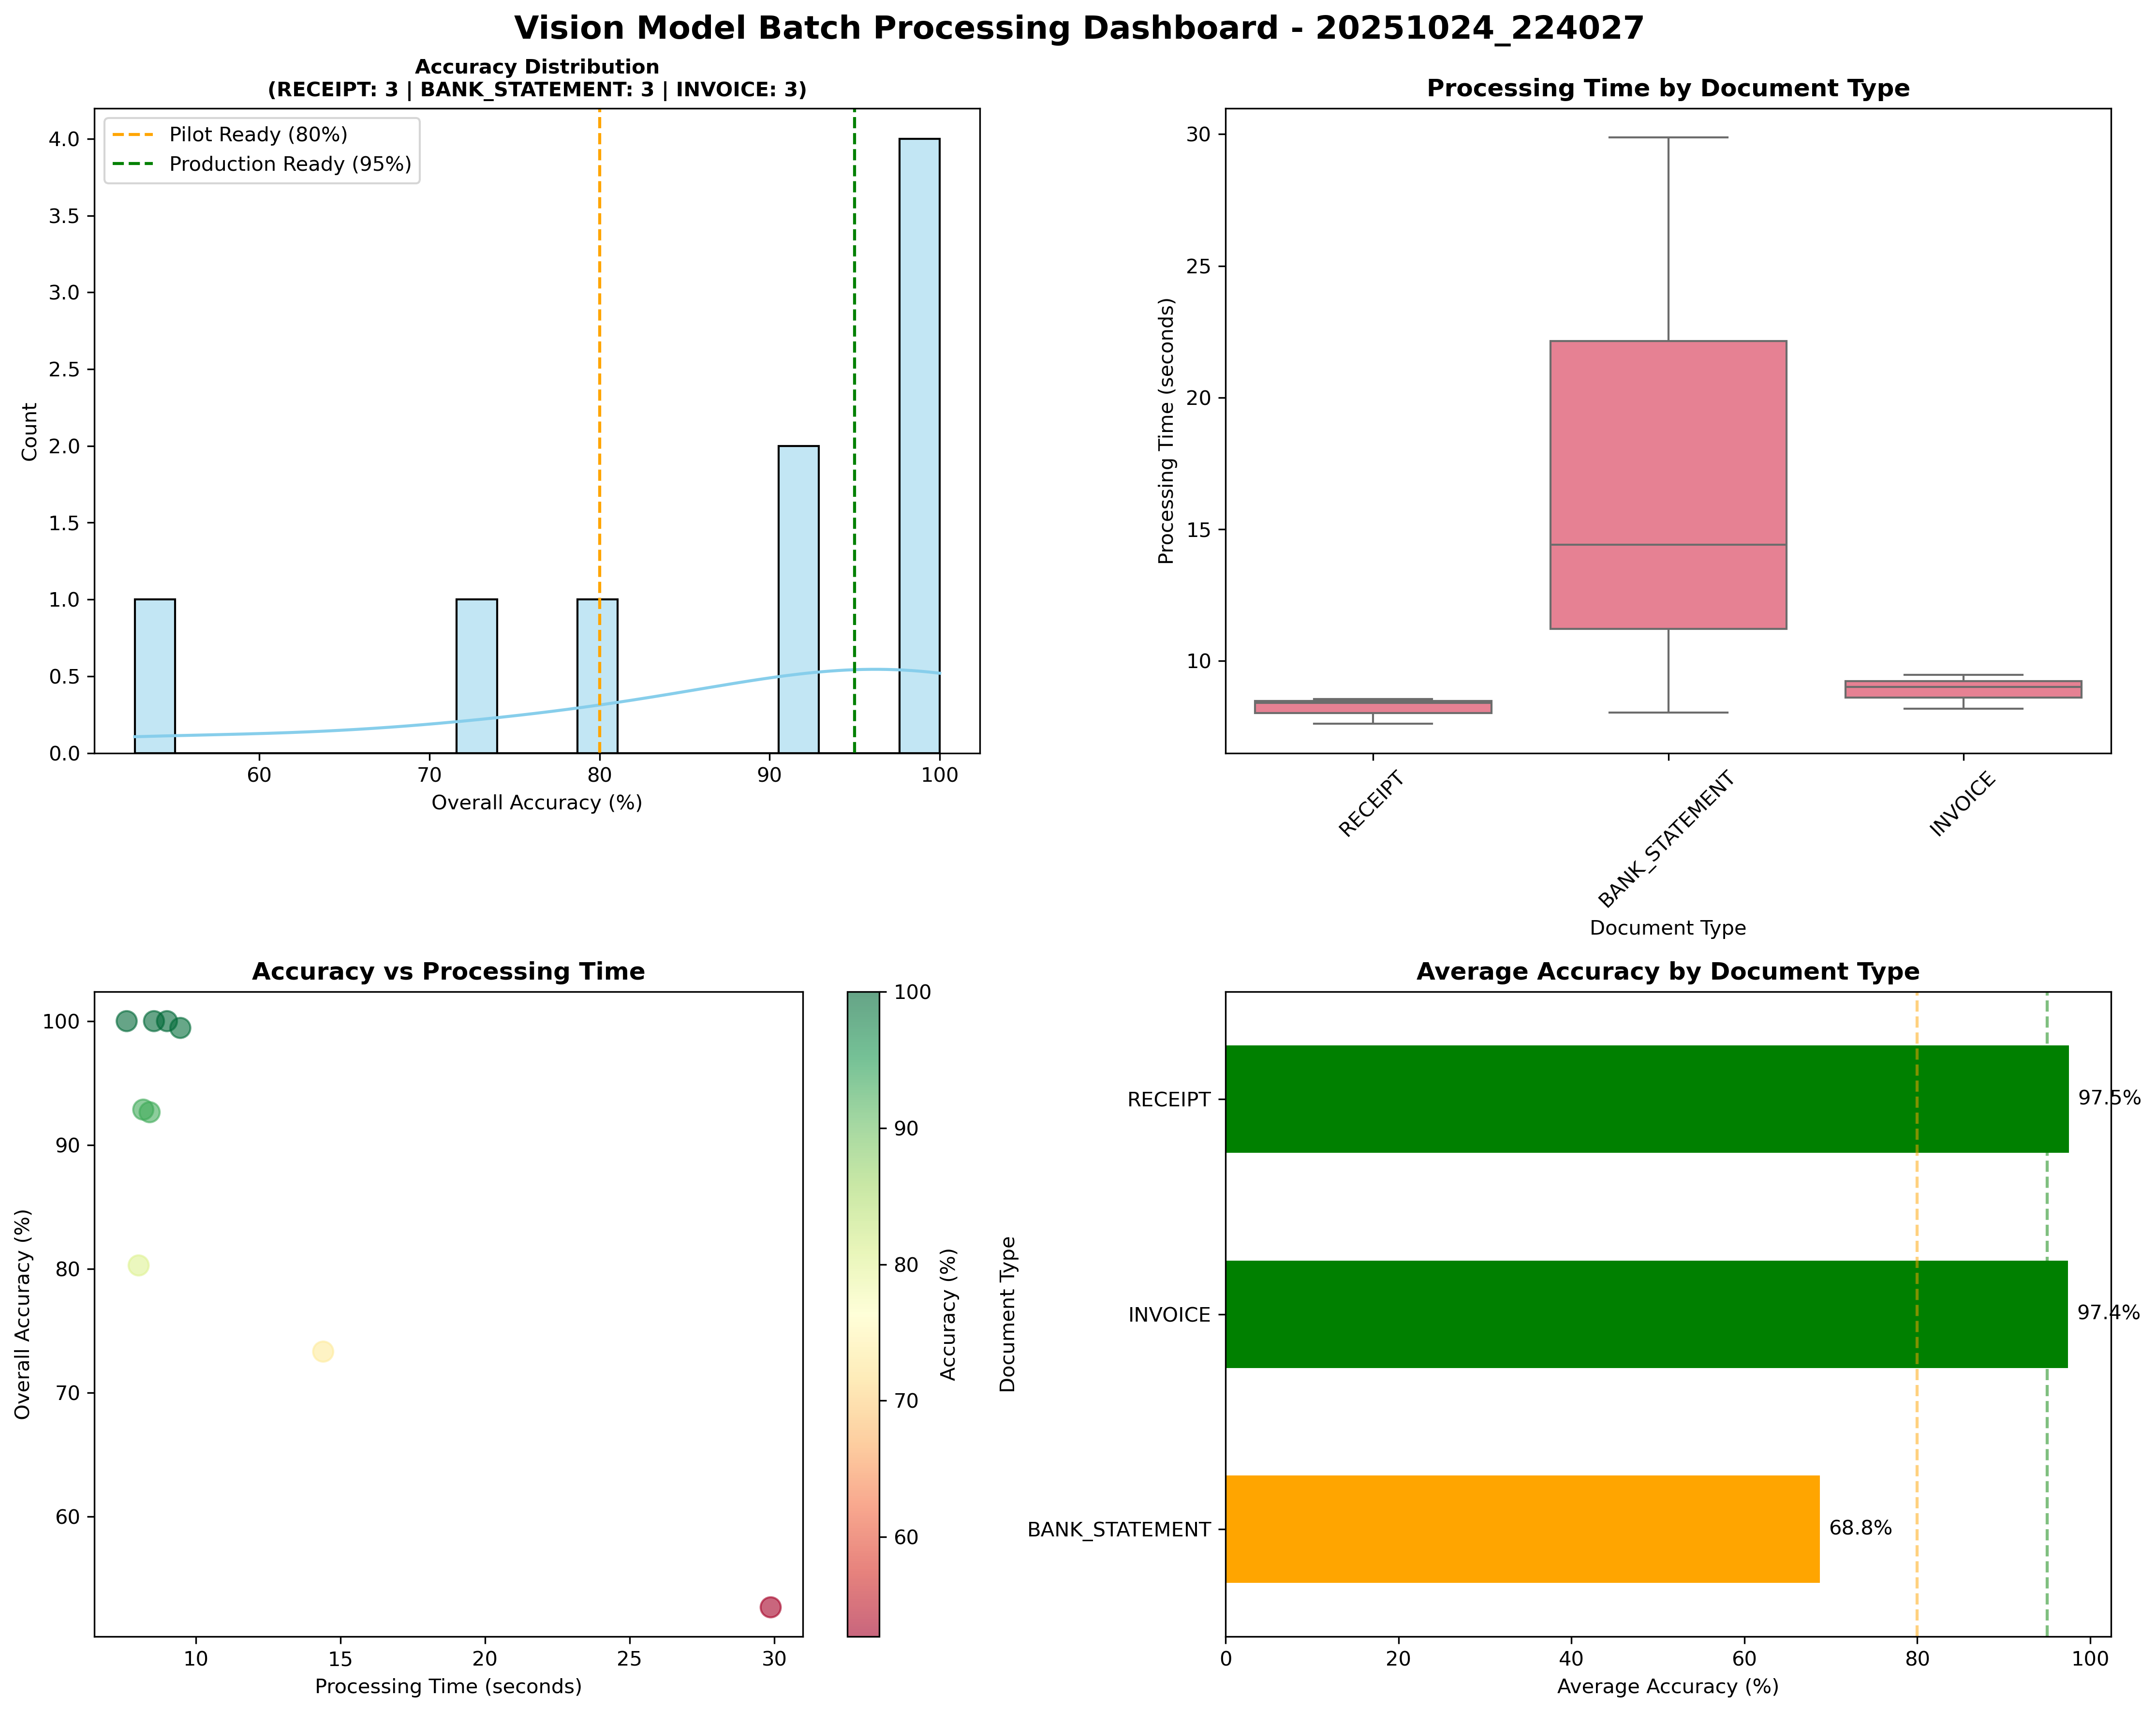

In [11]:
#Cell 11
# Display final summary
console.rule("[bold green]Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]‚úÖ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]üìä Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]‚ö†Ô∏è Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

In [12]:
#Cell 12
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]‚úÖ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]‚ö†Ô∏è Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Zero Accuracy Analysis ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

Total documents evaluated: 9

Documents with 0% accuracy: 0

‚úÖ No documents with 0% accuracy - all extractions had some success!